In [1]:
#pip install h5py nibabel pandas glob2 regex
import os
import sys
import numpy as np
import nibabel as nib
import h5py
import time
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product
import scipy
import torch
import torch.nn as nn
os.environ["CUDA_VISIBLE_DEVICES"]= '1' #, this way I would choose GPU 3 to do the work
import scipy.io as sio
from scipy.io import loadmat

In [2]:
with h5py.File('AllMaps_vanilla_Vol6.mat', 'r') as f:
    print(list(f.keys()))  # Zeigt dir die verfügbaren Variablennamen
    data = f['AllMaps']  # Beispiel: lade Dataset
    metabos = data['Metabos']
    Title = metabos['Title'][:]
    title_refs = metabos['Title']
    MetabMaps = metabos['Normal'][:]
    #print(list(data.keys()))
    #print(list(metabos.keys()))
    titles = []
    for ref in title_refs[0]:  # assuming shape (1, N)
        dset = f[ref]
        title = dset[:].tobytes().decode('utf-16-le')  # ← das ist der Trick
        titles.append(title)

with h5py.File('AllMaps_L2_Vol6.mat', 'r') as f:
    print(list(f.keys()))  # Zeigt dir die verfügbaren Variablennamen
    data = f['AllMaps']  # Beispiel: lade Dataset
    metabos = data['Metabos']
    Title = metabos['Title'][:]
    title_refs = metabos['Title']
    MetabMaps_L2 = metabos['Normal'][:]
    #print(list(data.keys()))
    #print(list(metabos.keys()))
    titles = []
    for ref in title_refs[0]:  # assuming shape (1, N)
        dset = f[ref]
        title = dset[:].tobytes().decode('utf-16-le')  # ← das ist der Trick
        titles.append(title)
    #print(titles)

with h5py.File('Vol6WithWater.mat', 'r') as f:
    print(list(f.keys()))  # Zeigt dir die verfügbaren Variablennamen
    data = f['AllMaps']  # Beispiel: lade Dataset
    metabos = data['Metabos']
    Title = metabos['Title'][:]
    title_refs = metabos['Title']
    MetabMaps_walinet_Water = metabos['Normal'][:]
    #print(list(data.keys()))
    #print(list(metabos.keys()))
    titles = []
    for ref in title_refs[0]:  # assuming shape (1, N)
        dset = f[ref]
        title = dset[:].tobytes().decode('utf-16-le')  # ← das ist der Trick
        titles.append(title)

with h5py.File('AllMaps_Hauke_Vol6.mat', 'r') as f:
    print(list(f.keys()))  # Zeigt dir die verfügbaren Variablennamen
    data = f['AllMaps']  # Beispiel: lade Dataset
    metabos = data['Metabos']
    Title = metabos['Title'][:]
    title_refs = metabos['Title']
    MetabMaps_walinet = metabos['Normal'][:]
    #print(list(data.keys()))
    #print(list(metabos.keys()))
    titles = []
    for ref in title_refs[0]:  # assuming shape (1, N)
        dset = f[ref]
        title = dset[:].tobytes().decode('utf-16-le')  # ← das ist der Trick
        titles.append(title)
    #print(titles)

['#refs#', 'AllMaps', 'Par', 'WaterRefState', 'out_dir', 'tmp_dir']
['#refs#', 'AllMaps', 'Par', 'WaterRefState', 'out_dir', 'tmp_dir']
['#refs#', 'AllMaps', 'Par', 'WaterRefState', 'out_dir', 'tmp_dir']
['#refs#', 'AllMaps', 'Par', 'WaterRefState', 'out_dir', 'tmp_dir']


In [3]:
mask = np.load('../data/Vol6/masks/brain_mask.npy')

In [4]:
mask.shape

(64, 64, 35)

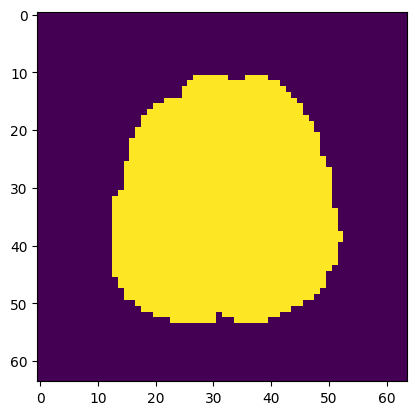

In [16]:
z = 17

Slice = mask[:,:,z]

plt.imshow(Slice)

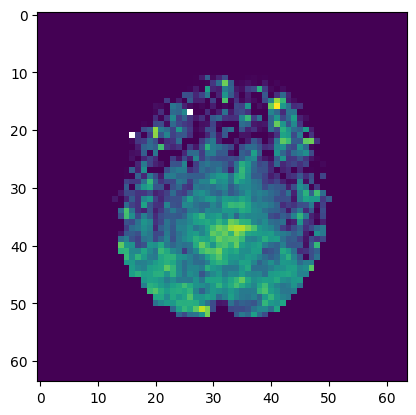

In [17]:
metab = 1

plt.imshow(maps_walinet_water[metab,:,:]*Slice)

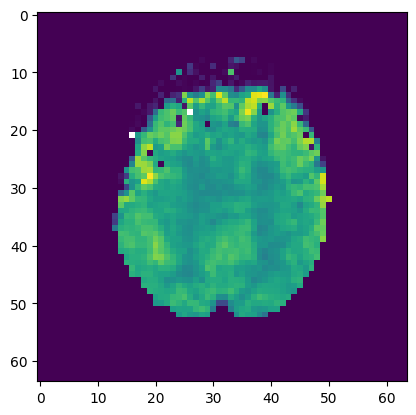

In [60]:
metab = 17

MAP = maps_walinet_water[metab,:,:]

p = 20

cutoff = np.nanpercentile(np.abs(MAP), p)

filtered = MAP.copy()
filtered[np.abs(filtered) < cutoff] = 0

plt.imshow(filtered)

In [45]:
cutoff


np.float64(nan)

In [43]:
MAP[30,30]

np.float64(0.000765)

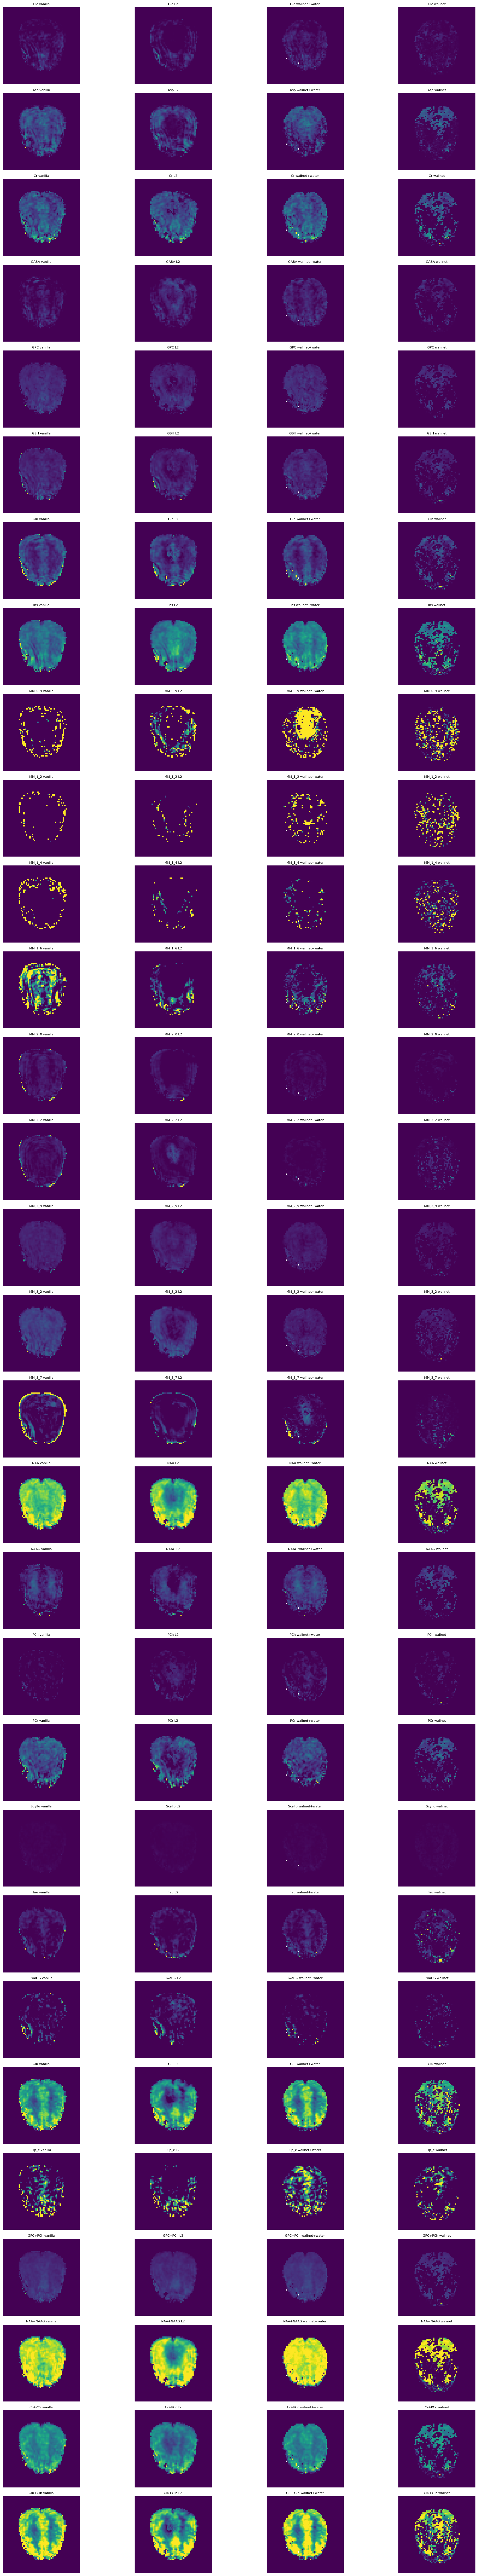

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the 17th channel from each map set
maps_vanilla        = MetabMaps[:, 17, :, :]
maps_L2             = MetabMaps_L2[:, 17, :, :]
maps_walinet_water  = MetabMaps_walinet_Water[:, 17, :, :]
maps_walinet        = MetabMaps_walinet[:, 17, :, :]

# Gemeinsame Farbskala basierend auf 1.–99. Perzentil aller vier Sets
combined = np.concatenate([
    maps_vanilla.flatten(),
    maps_L2.flatten(),
    maps_walinet_water.flatten(),
    maps_walinet.flatten()
])
vmin, vmax = np.nanpercentile(combined[np.isfinite(combined)], [1, 99])

# Erstelle eine Figur mit 4 Spalten: vanilla, L2, walinet+water, walinet
n = len(titles)
fig, axes = plt.subplots(nrows=n, ncols=4,
                         figsize=(5 * 4, n * 3),
                         squeeze=False)

for i, title in enumerate(titles):
    # Vanilla-Map
    axes[i, 0].imshow(
        maps_vanilla[i]*Slice, cmap='viridis', vmin=vmin, vmax=vmax, origin='lower'
    )
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"{title} vanilla", fontsize=8)

    # L2-Map
    axes[i, 1].imshow(
        maps_L2[i]*Slice, cmap='viridis', vmin=vmin, vmax=vmax, origin='lower'
    )
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"{title} L2", fontsize=8)

    # Walinet+Water-Map
    axes[i, 2].imshow(
        maps_walinet_water[i]*Slice, cmap='viridis', vmin=vmin, vmax=vmax, origin='lower'
    )
    axes[i, 2].axis('off')
    axes[i, 2].set_title(f"{title} walinet+water", fontsize=8)

    # Walinet-Map
    axes[i, 3].imshow(
        maps_walinet[i], cmap='viridis', vmin=vmin, vmax=vmax, origin='lower'
    )
    axes[i, 3].axis('off')
    axes[i, 3].set_title(f"{title} walinet", fontsize=8)

plt.tight_layout()
plt.show()


